In [2]:
# === AGCD SON extraction (per-city output, assumes variable names: time, lat, lon, precip) ===
# Paste and run in a Jupyter notebook cell.
import os
import numpy as np
import xarray as xr
import pandas as pd

In [3]:
# -------------------- User parameters --------------------
data_dir = '/g/data/zv2/agcd/v1-0-3/precip/total/r005/01day'   # directory with yearly AGCD files; change as needed
fname_template = 'agcd_v1_precip_total_r005_daily_{year}.nc'
output_dir = '.'  # where per-city NetCDFs will be written
os.makedirs(output_dir, exist_ok=True)

years_all = list(range(1950, 2025))  # inclusive 1950-2024

# Cities and coordinates
# cities = ["Sydney", "Melbourne", "Brisbane", "Perth", "Adelaide", "Canberra", "Hobart", "Darwin"]
# city_lat = np.array([-33.8688, -37.8136, -27.4698, -31.9505, -34.9285, -35.2809, -42.8821, -12.4637])
# city_lon = np.array([151.2093, 144.9631, 153.0251, 115.8605, 138.6007, 149.1300, 147.3210, 130.8444])
cities = [ "Darwin"]
city_lat = np.array([ -12.4637])
city_lon = np.array([130.8444])

# ENSO year lists (as provided)
EP_ElNino_year = [1952, 1958, 1973, 1977, 1983, 1988, 1998, 2007, 2016, 2024]
CP_ElNino_year = [1954, 1964, 1966, 1969, 1978, 1987, 1992, 1995, 2003, 2005, 2010, 2019]
EP_LaNina_year = [1955, 1956, 1971, 1972, 1985, 1996, 2000, 2008, 2018, 2021]
CP_LaNina_year = [1965, 1974, 1976, 1984, 1989, 1999, 2001, 2011, 2012, 2022, 2023]

enso_labels = ['EP_ElNino', 'CP_ElNino', 'EP_LaNina', 'CP_LaNina']
enso_years = {
    'EP_ElNino': EP_ElNino_year,
    'CP_ElNino': CP_ElNino_year,
    'EP_LaNina': EP_LaNina_year,
    'CP_LaNina': CP_LaNina_year
}

SON_months = [9, 10, 11]
SON_n_days = 91  # Sep(30)+Oct(31)+Nov(30)

In [4]:
def extract_city_son_from_year(ds, city_lon, city_lat):
    """
    Extract SON daily precipitation for one city from one AGCD yearly file.
    Assumes:
      - ds has 1D coordinates: lat(lat), lon(lon)
      - lon range is ~112–156 (no normalization needed)
      - variable name is 'precip'
    Returns: 1D numpy array of length 91 (SON daily values)
    """

    lon = ds['lon'].values
    lat = ds['lat'].values

    # find indices of the grid cell that contains the city
    i = np.searchsorted(lon, city_lon)
    j = np.searchsorted(lat, city_lat)

    # bounding indices (4 surrounding grid points)
    i0, i1 = i - 1, i
    j0, j1 = j - 1, j

    # extract 2x2 grid box and average
    pr = ds['precip'].isel(
        lon=[i0, i1],
        lat=[j0, j1]
    ).mean(dim=('lon', 'lat'))

    # select SON days
    time = pd.to_datetime(ds['time'].values)
    son_mask = time.month.isin([9, 10, 11])

    return pr.values[son_mask]

In [5]:
# -------------------- Main processing --------------------
# For each city: for each ENSO type, loop years and extract SON (91 days) into array, then save per-city file.

for ci, city in enumerate(cities):
    print(f"\nProcessing city {ci+1}/{len(cities)}: {city}")
    lon_pt = city_lon[ci]
    lat_pt = city_lat[ci]

    # container for this city
    city_result = {}

    # determine max years across ENSO types for alignment
    max_n_years = max(len(enso_years[ens]) for ens in enso_labels)

    for enso in enso_labels:
        years = enso_years[enso]
        n_years = len(years)
        arr = np.full((n_years, SON_n_days), np.nan, dtype=float)

        print(f"  ENSO: {enso} ({n_years} years)")
        for yi, yr in enumerate(years):
            fname = os.path.join(data_dir, fname_template.format(year=yr-1)) # use previous year for SON
            # we assume file exists (per your note)
            ds = xr.open_dataset(fname)
            try:
                son_vals = extract_city_son_from_year(ds, lon_pt, lat_pt)
            finally:
                ds.close()

            # align: if length shorter (shouldn't happen if AGCD daily complete), left-align and keep NaNs
            if son_vals is not None and son_vals.size > 0:
                nvals = son_vals.size
                if nvals >= SON_n_days:
                    arr[yi, :] = son_vals[:SON_n_days]
                else:
                    arr[yi, :nvals] = son_vals
            else:
                # leave NaNs if extraction returned empty
                pass

        city_result[enso] = {'years': np.array(years, dtype=int), 'data': arr}

    # align into common shape (enso_type, max_n_years, day)
    prcp = np.full((len(enso_labels), max_n_years, SON_n_days), np.nan, dtype=float)
    year_coord = np.full((len(enso_labels), max_n_years), np.nan, dtype=float)

    for ei, enso in enumerate(enso_labels):
        data = city_result[enso]['data']
        yrs = city_result[enso]['years']
        n_y = data.shape[0]
        prcp[ei, :n_y, :] = data
        year_coord[ei, :n_y] = yrs


    # build xarray Dataset and save per-city NetCDF
    ds_out = xr.Dataset(
        {
            'prcp_son': (('enso_type', 'year_index', 'day'), prcp)
        },
        coords={
            'enso_type': enso_labels,
            'year_index': np.arange(1, max_n_years + 1),
            'day': np.arange(1, SON_n_days + 1),
            'year': (('enso_type', 'year_index'), year_coord),
            'city_lat': city_lat[ci],
            'city_lon': city_lon[ci]
        },
        attrs={
            'description': 'SON daily precipitation for city, grouped by ENSO type.',
            'notes': 'day index 1..91 corresponds to SON days in chronological order for each year file'
        }
    )

    ds_out['prcp_son'].attrs['units'] = 'mm/day'
    ds_out['prcp_son'].attrs['long_name'] = f'SON daily precipitation for {city} (mean of 4 surrounding gridpoints)'

    outfn = os.path.join(output_dir, f'{city}_son_daily_by_ENSO.nc')
    encoding = {'prcp_son': {'zlib': True, 'complevel': 4}}
    ds_out.to_netcdf(outfn, encoding=encoding)
    print(f"  -> Saved: {outfn}  (shape: {prcp.shape})")

print("\nFinished. All per-city files saved in:", os.path.abspath(output_dir))
# ----------------------------------------------------------------------------------------


Processing city 1/1: Darwin
  ENSO: EP_ElNino (10 years)
  ENSO: CP_ElNino (12 years)
  ENSO: EP_LaNina (10 years)
  ENSO: CP_LaNina (11 years)
  -> Saved: ./Darwin_son_daily_by_ENSO.nc  (shape: (4, 12, 91))

Finished. All per-city files saved in: /g/data/if69/ls3248/data/AGCD/precip/daily/city


/scratch/m35/ls3248/tmp/ipykernel_1135557/2638509852.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


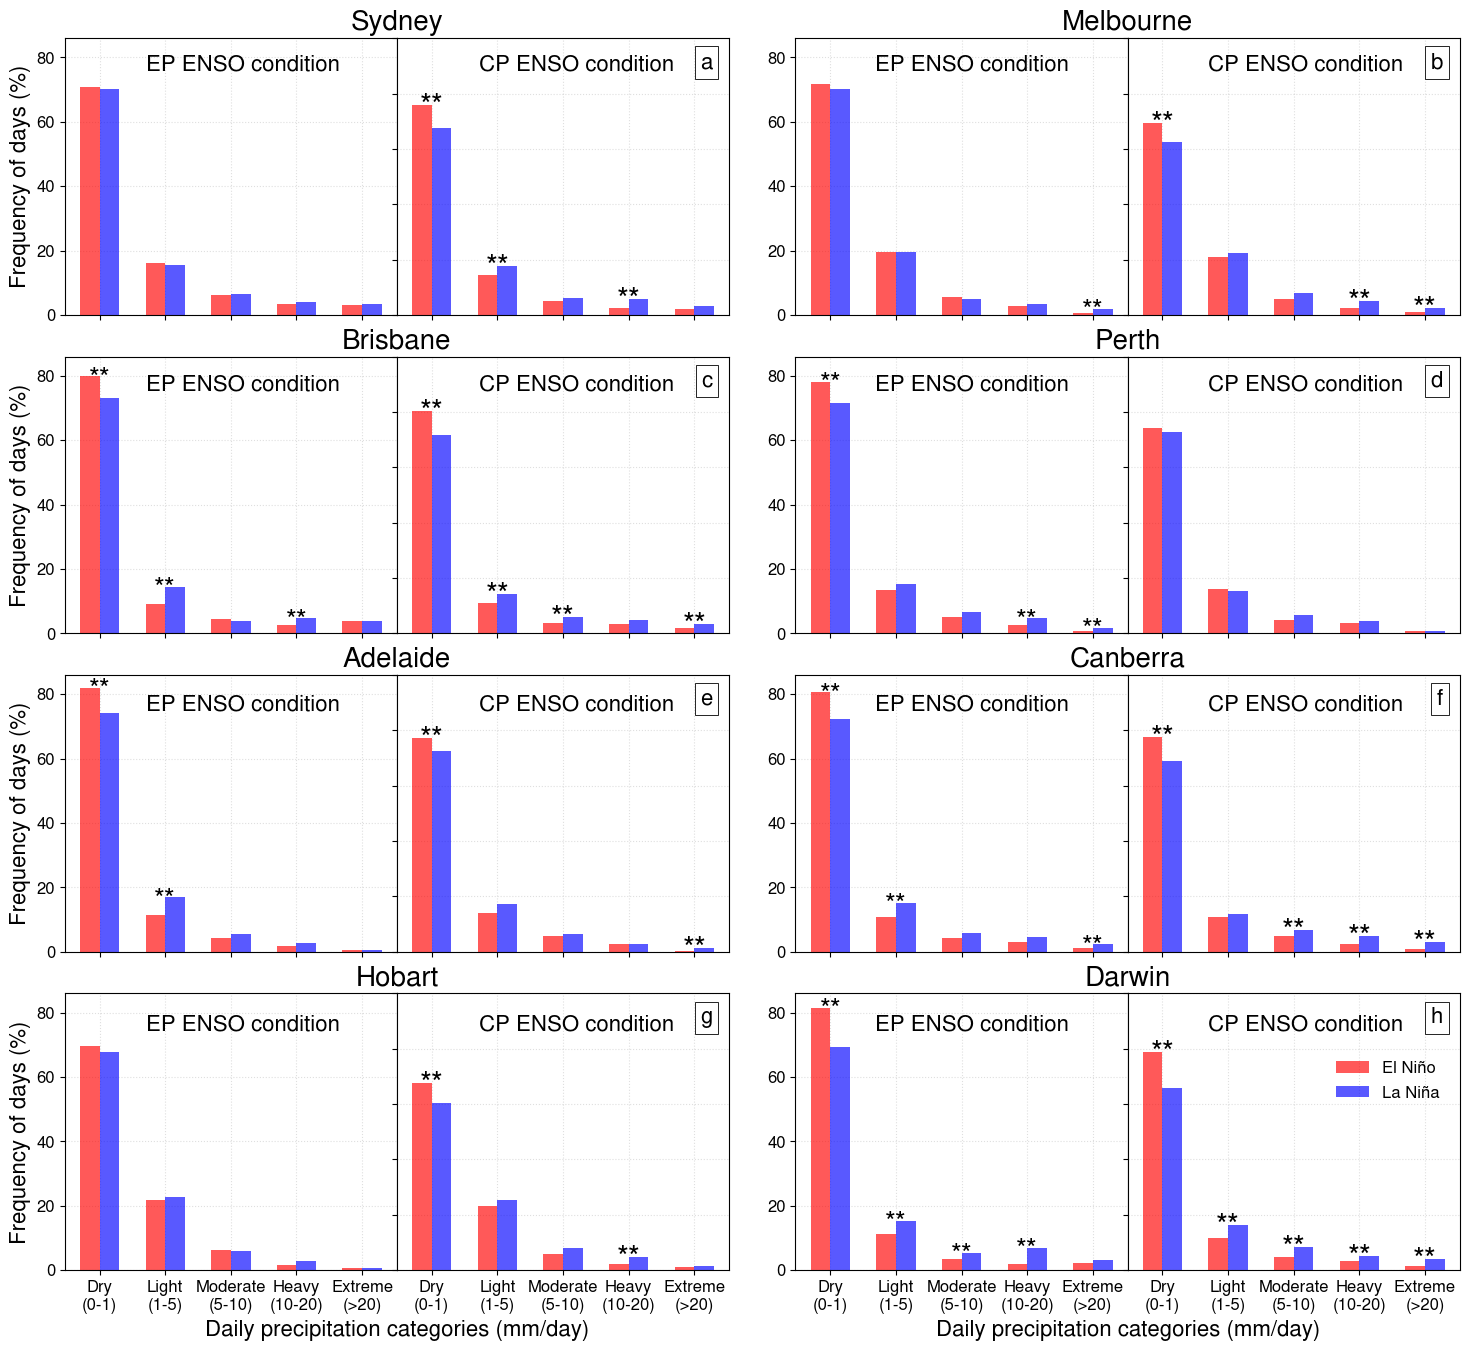

Saved: 8cities_EP_CP_categories_4x2_withStars_and_labels.pdf


In [ ]:
# Categorical-frequency version with per-category proportion z-test annotations
# For each ENSO class show categorical probabilities:
# categories = ['Dry', 'Light', 'Moderate', 'Heavy', 'Extreme']
# Layout: 8 cities (4x2), each city: EP (left) & CP (right) tightly adjacent.
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpecFromSubplotSpec, GridSpec
import math
import matplotlib as mpl

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = [
    'Helvetica',
    'Arial',
    'Nimbus Sans',
    'Liberation Sans',
    'DejaVu Sans'
]

# -------------- user settings --------------
cities = ["Sydney", "Melbourne", "Brisbane", "Perth",
          "Adelaide", "Canberra", "Hobart", "Darwin"]
fn_template = "./{city}_son_daily_by_ENSO.nc"
out_png = "8cities_EP_CP_categories_4x2_withStars_and_labels.pdf"

figsize = (18, 16)
nrows, ncols = 4, 2
y_max = 86

# categories and helper functions
cats = ['Dry', 'Light', 'Moderate', 'Heavy', 'Extreme']
ncat = len(cats)
def pct(arr, cond):
    if arr.size == 0:
        return np.nan
    return 100.0 * np.sum(cond(arr)) / arr.size

def load_city_data(fn):
    ds = xr.open_dataset(fn)
    enso_types = list(ds['enso_type'].values)
    try:
        lookup = {str(v): i for i, v in enumerate(enso_types)}
    except Exception:
        lookup = {}
    keys = ['EP_ElNino','CP_ElNino','EP_LaNina','CP_LaNina']
    idx_map = {k: lookup.get(k, i) for i, k in enumerate(keys)}
    data = {}
    for k in keys:
        idx = idx_map[k]
        arr = ds['prcp_son'].isel(enso_type=idx).values
        year = ds['year'].isel(enso_type=idx).values
        valid = ~np.isnan(year)
        allv = arr[valid, :].ravel()
        allv = allv[~np.isnan(allv)]
        data[k] = {'all': allv}
    ds.close()
    return data

# pooled two-sample proportion z-test (returns p-value)
def two_prop_ztest(count1, n1, count2, n2):
    # handle degenerate cases
    if n1 == 0 or n2 == 0:
        return np.nan
    p1 = count1 / n1
    p2 = count2 / n2
    p_pool = (count1 + count2) / (n1 + n2)
    se = math.sqrt(p_pool * (1 - p_pool) * (1.0 / n1 + 1.0 / n2))
    if se == 0:
        return np.nan
    z = (p1 - p2) / se
    # two-sided p-value using normal CDF via erf
    pval = 2.0 * (1.0 - 0.5 * (1.0 + math.erf(abs(z) / math.sqrt(2.0))))
    return pval

# --- Precompute category percentages and raw counts for every city & ENSO subtype ---
city_results = {}
for city in cities:
    data = load_city_data(fn_template.format(city=city))
    freqs = {}
    counts = {}   # raw counts and totals so we can test
    for k in ['EP_ElNino','EP_LaNina','CP_ElNino','CP_LaNina']:
        arr = data[k]['all']
        N = arr.size
        # categories counts (use same category definitions as your final choice)
        c0    = np.sum((arr >= 0.0) & (arr < 1.0))   # Dry
        c0_1  = np.sum((arr >= 1.0) & (arr < 5.0))   # Light
        c1_5  = np.sum((arr >= 5.0) & (arr < 10.0))  # Moderate
        c5_10 = np.sum((arr >= 10.0) & (arr < 20.0)) # Heavy (10-20)
        c_gt20= np.sum(arr >= 20.0)                  # Extreme
        cnts = np.array([c0, c0_1, c1_5, c5_10, c_gt20], dtype=int)
        # convert to percent of all days
        pct_arr = 100.0 * cnts / N if N > 0 else np.zeros_like(cnts, dtype=float)
        freqs[k] = pct_arr
        counts[k] = {'counts': cnts, 'N': N}
    city_results[city] = {'freqs': freqs, 'counts': counts}

# --- Plotting & annotation ---
fig = plt.figure(figsize=figsize)
outer = GridSpec(nrows, ncols, figure=fig, hspace=0.15, wspace=0.1)

# bar layout parameters (for categories)
x = np.arange(ncat)                     # category positions
bw = 0.3                               # width of each group's bars (El / La)
offset = bw / 2.0                       # horizontal shift for pairing

for i, city in enumerate(cities):
    r, c = divmod(i, ncols)
    inner = GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[r, c], wspace=0.0)
    ax_ep = fig.add_subplot(inner[0])
    ax_cp = fig.add_subplot(inner[1])

    freqs = city_results[city]['freqs']
    counts = city_results[city]['counts']

    # EP: plot EP_ElNino (red) and EP_LaNina (blue) as paired bars across categories
    ep_el = freqs['EP_ElNino']
    ep_la = freqs['EP_LaNina']
    bars_ep_el = ax_ep.bar(x - offset, ep_el, width=bw, color="red", alpha=0.65, zorder=2)
    bars_ep_la = ax_ep.bar(x + offset, ep_la, width=bw, color="blue", alpha=0.65, zorder=2)

    # perform proportion tests for EP categories and annotate '**' if p < 0.05
    for j in range(ncat):
        k_el = int(counts['EP_ElNino']['counts'][j])
        N_el = int(counts['EP_ElNino']['N'])
        k_la = int(counts['EP_LaNina']['counts'][j])
        N_la = int(counts['EP_LaNina']['N'])
        pval = two_prop_ztest(k_el, N_el, k_la, N_la)
        if not (pval is None or np.isnan(pval)) and pval < 0.05:
            # place '**' at center x position j, y slightly above taller bar
            top_y = max(ep_el[j], ep_la[j])
            # place with a small offset in data units but ensure inside axis
            ytext = top_y-1
            ax_ep.text(j, ytext, '**', ha='center', va='center', fontsize=20, color='k', zorder=5)

    ax_ep.set_ylim(0, y_max)
    ax_ep.tick_params(axis='y', labelsize=12)
    ax_ep.set_title(city, fontsize=20)
    ax_ep.title.set_position((1,1))

    ax_ep.grid(True, linestyle=':', alpha=0.4)

    # CP: plot CP_ElNino and CP_LaNina
    cp_el = freqs['CP_ElNino']
    cp_la = freqs['CP_LaNina']
    bars_cp_el = ax_cp.bar(x - offset, cp_el, width=bw, color="red", alpha=0.65, zorder=2)
    bars_cp_la = ax_cp.bar(x + offset, cp_la, width=bw, color="blue", alpha=0.65, zorder=2)

    # perform proportion tests for CP categories and annotate '**' if p < 0.05
    for j in range(ncat):
        k_el = int(counts['CP_ElNino']['counts'][j])
        N_el = int(counts['CP_ElNino']['N'])
        k_la = int(counts['CP_LaNina']['counts'][j])
        N_la = int(counts['CP_LaNina']['N'])
        pval = two_prop_ztest(k_el, N_el, k_la, N_la)
        if not (pval is None or np.isnan(pval)) and pval < 0.05:
            top_y = max(cp_el[j], cp_la[j])
            ytext = top_y-1
            ax_cp.text(j, ytext, '**', ha='center', va='center', fontsize=22, color='k', zorder=5)

    # add boxed letter label to CP panel right-top (use axes coordinates)
    # letters list is aligned with city index; place in upper-right corner
    # prepare labels (a),(b),... for CP panels
    letters = [chr(ord("a") + i) for i in range(len(cities))]
    lab = letters[i]
    ax_cp.text(0.95, 0.95, lab,
               transform=ax_cp.transAxes,
               ha='right', va='top',
               fontsize=16,
               bbox=dict( facecolor='white', edgecolor='k', linewidth=0.6),
               zorder=10)

    ax_cp.set_ylim(0, y_max)
    ax_cp.grid(True, linestyle=':', alpha=0.4)
    ax_cp.set_yticks(ax_ep.get_yticks())   
    ax_cp.set_yticklabels([])              

    # ---- x-axis ticks and labels (only show for last row) ----
    ax_ep.set_xticks(x)
    ax_cp.set_xticks(x)

    cats_long = ['Dry\n(0-1)','Light\n(1-5)','Moderate\n(5-10)','Heavy\n(10-20)','Extreme\n(>20)']
    if i in [6, 7]:   # Hobart, Darwin
        ax_ep.set_xticklabels(cats_long, fontsize=12, rotation=0)
        ax_cp.set_xticklabels(cats_long, fontsize=12, rotation=0)
        ax_ep.set_xlabel('Daily precipitation categories (mm/day)', fontsize=16, labelpad=8)
        ax_ep.xaxis.set_label_coords(1., -0.18)
    else:
        ax_ep.set_xticklabels([])
        ax_cp.set_xticklabels([])
        ax_cp.set_ylabel('')

    if i in [0, 2, 4, 6]: 
        ax_ep.set_ylabel('Frequency of days (%)', fontsize=16)
    else:
        ax_ep.set_ylabel('')

# unified legend
legend_elements = [Patch(facecolor="red", alpha=0.65, label='El Niño'),
                   Patch(facecolor="blue", alpha=0.65, label='La Niña')]
fig.legend(handles=legend_elements, loc='upper center', fontsize=12, ncol = 1, bbox_to_anchor=(0.86, 0.25), frameon=False)

fig.text(0.17, 0.86, 'EP ENSO condition',fontsize=16)
fig.text(0.355, 0.86, 'CP ENSO condition',fontsize=16)
fig.text(0.575, 0.86, 'EP ENSO condition',fontsize=16)
fig.text(0.76, 0.86, 'CP ENSO condition',fontsize=16)

fig.text(0.17, 0.66, 'EP ENSO condition',fontsize=16)
fig.text(0.355, 0.66, 'CP ENSO condition',fontsize=16)
fig.text(0.575, 0.66, 'EP ENSO condition',fontsize=16)
fig.text(0.76, 0.66, 'CP ENSO condition',fontsize=16)

fig.text(0.17, 0.46, 'EP ENSO condition',fontsize=16)
fig.text(0.355, 0.46, 'CP ENSO condition',fontsize=16)
fig.text(0.575, 0.46, 'EP ENSO condition',fontsize=16)
fig.text(0.76, 0.46, 'CP ENSO condition',fontsize=16)

fig.text(0.17, 0.26, 'EP ENSO condition',fontsize=16)
fig.text(0.355, 0.26, 'CP ENSO condition',fontsize=16)
fig.text(0.575, 0.26, 'EP ENSO condition',fontsize=16)
fig.text(0.76, 0.26, 'CP ENSO condition',fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig(out_png, bbox_inches='tight', dpi=200)
plt.show()
print("Saved:", out_png)
